In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from flux_modeller.utilities.raw_csv_utils import get_parameters_dict, scrape_parameters
from flux_modeller.utilities.files import generate_file_name
from flux_modeller.preprocessing.curve import create_training_dataset, create_sklearn_inputs_and_targets
from flux_modeller.training.curve import fit_linear_model
from flux_modeller.model import CurveModel

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from copy import copy 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define some useful functions that get reused.

In [108]:
def normalize(a, b):
    """
    Normalize two sets of arrays according to element-wise max values.
    
    Note: `a` and `b` must be an array of arrays
   
   """
    a = copy(a)
    b = copy(b)
    
    for i, (aa, bb) in enumerate(zip(a, b)):  # For each array
        scaler = max(aa)
        a[i] = aa / scaler  # normalize
        b[i] = bb / scaler
    return a, b


# Read FEA data from disk

In [6]:
df = pd.read_csv('../data/fea-flux-curves-numr[1-5-200]-numz[1-5-200]-wdiam[0.143].csv')
df.head()

,Time [ms],FluxLinkage(Winding1) [Wb] - winding_num_r='1' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='6' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='11' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='16' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='21' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='26' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='31' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='36' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='41' winding_num_z='1',...,FluxLinkage(Winding1) [Wb] - winding_num_r='156' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='161' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='166' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='171' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='176' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='181' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='186' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='191' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='196' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='200' winding_num_z='200'
0,0,-2.099521e-08,-1.387548e-07,-2.791328e-07,-4.438366e-07,-6.345414e-07,-8.527954e-07,-0.000001,-0.000001,-0.000002,...,-0.004291,-0.004550,-0.004814,-0.005083,-0.005356,-0.005633,-0.005913,-0.006196,-0.006482,-0.006711
1,5,-2.326445e-08,-1.537364e-07,-3.092429e-07,-4.917020e-07,-7.029106e-07,-9.445925e-07,-0.000001,-0.000002,-0.000002,...,-0.004539,-0.004808,-0.005083,-0.005362,-0.005646,-0.005933,-0.006224,-0.006517,-0.006812,-0.007050
2,10,-2.581092e-08,-1.705559e-07,-3.430579e-07,-5.454348e-07,-7.796765e-07,-1.047708e-06,-0.000001,-0.000002,-0.000002,...,-0.004928,-0.005216,-0.005509,-0.005808,-0.006110,-0.006415,-0.006725,-0.007036,-0.007350,-0.007602
3,15,-2.858835e-08,-1.889002e-07,-3.799357e-07,-6.040307e-07,-8.633812e-07,-1.160117e-06,-0.000001,-0.000002,-0.000002,...,-0.005408,-0.005720,-0.006039,-0.006362,-0.006689,-0.007019,-0.007353,-0.007690,-0.008028,-0.008300
4,20,-3.177372e-08,-2.099363e-07,-4.222200e-07,-6.711804e-07,-9.592931e-07,-1.288844e-06,-0.000002,-0.000002,-0.000003,...,-0.005974,-0.006316,-0.006665,-0.007018,-0.007376,-0.007736,-0.008101,-0.008467,-0.008836,-0.009132


# Preprocessing
Here we convert the time units to seconds, and convert the displacement to metres.

In [7]:
velocity = 0.35  # metres per second, hardcoded from FEA simulation
df['time(s)'] = df.iloc[:,0]/1000
df['displacement(m)'] = df['time(s)']*velocity

df.head()

,Time [ms],FluxLinkage(Winding1) [Wb] - winding_num_r='1' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='6' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='11' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='16' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='21' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='26' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='31' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='36' winding_num_z='1',FluxLinkage(Winding1) [Wb] - winding_num_r='41' winding_num_z='1',...,FluxLinkage(Winding1) [Wb] - winding_num_r='166' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='171' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='176' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='181' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='186' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='191' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='196' winding_num_z='200',FluxLinkage(Winding1) [Wb] - winding_num_r='200' winding_num_z='200',time(s),displacement(m)
0,0,-2.099521e-08,-1.387548e-07,-2.791328e-07,-4.438366e-07,-6.345414e-07,-8.527954e-07,-0.000001,-0.000001,-0.000002,...,-0.004814,-0.005083,-0.005356,-0.005633,-0.005913,-0.006196,-0.006482,-0.006711,0.000,0.00000
1,5,-2.326445e-08,-1.537364e-07,-3.092429e-07,-4.917020e-07,-7.029106e-07,-9.445925e-07,-0.000001,-0.000002,-0.000002,...,-0.005083,-0.005362,-0.005646,-0.005933,-0.006224,-0.006517,-0.006812,-0.007050,0.005,0.00175
2,10,-2.581092e-08,-1.705559e-07,-3.430579e-07,-5.454348e-07,-7.796765e-07,-1.047708e-06,-0.000001,-0.000002,-0.000002,...,-0.005509,-0.005808,-0.006110,-0.006415,-0.006725,-0.007036,-0.007350,-0.007602,0.010,0.00350
3,15,-2.858835e-08,-1.889002e-07,-3.799357e-07,-6.040307e-07,-8.633812e-07,-1.160117e-06,-0.000001,-0.000002,-0.000002,...,-0.006039,-0.006362,-0.006689,-0.007019,-0.007353,-0.007690,-0.008028,-0.008300,0.015,0.00525
4,20,-3.177372e-08,-2.099363e-07,-4.222200e-07,-6.711804e-07,-9.592931e-07,-1.288844e-06,-0.000002,-0.000002,-0.000003,...,-0.006665,-0.007018,-0.007376,-0.007736,-0.008101,-0.008467,-0.008836,-0.009132,0.020,0.00700


## Create training samples

In [8]:
waveform_cols = df.columns[1:-2]
training_samples = create_training_dataset(df,
                                           waveform_cols,
                                           shift_peak_to_zero=True,
                                           smooth_filter=False)  # Don't smooth filter

100%|██████████| 1682/1682 [00:02<00:00, 587.93it/s]


# Model Training

Let's just describe the model briefly here.

Assume we have input data $X \rightarrow (n, d)$ where $n$ is the number of samples and $d$ is the number of dimensions,
and target data $Y \rightarrow (n, p)$ where $p$ is the number of points for each of the $n$ flux curves.

First we create an unweighted "kernel space", $K_s \rightarrow (p, k)$, where $p$ is the number of discrete points we want to consider and $k$ is the number of kernels.

Next, we find the optimal weights of each kernel to recreate each flux curve $Y$, using a linear regression model with ordinary least squares parameter estimation. 

The model looks like this:

$(K_s \cdot W_k)^T = \hat{Y}$,
where $W_k$ has dimensions $(k, n)$ so that our predicted values $\hat{Y}$ has the same dimension as our target $Y$, i.e. $(n, p)$.

We then train a **second** linear regression model to predict the kernel weights $W_k$ given $X$, such that:

$(X \cdot W_W)^T = \hat{W_k}$

We can then substitute in $\hat{W_k}$ in the equation above to get a prediction for the flux curve given $X$:

\begin{align}
(K_s \cdot \hat{W_k})^T &= \hat{Y} \\
(K_s \cdot (X \cdot W_W)^T)^T &= \hat{Y}
\end{align}

Replace $Y$ with our flux curves $\Phi$ and you have your flux curve model.

## Hyperparameter optimization (skip if already done)
For number of kernels $k$ and kernel shape parameter $s$ and kernel magnitude `mag`.

In [10]:
import nevergrad as ng
from sklearn.preprocessing import PolynomialFeatures


# Variables are used in the `minimze` function
num_polynomials = 5
xs = training_samples[0]['dataframe']['displacement(m)'].values

# TODO: Turn this into a cross-validation kind of system (maybe)
def minimize(k, mag, shape):
    samples_train, samples_validate = train_test_split(training_samples, train_size=0.1)  # Resample each cycle. See this as a rough "regularization".
    X_train, y_train = create_sklearn_training_data(samples_train)
    X_val, y_val = create_sklearn_training_data(samples_validate)
    
    X_train = PolynomialFeatures(num_polynomials).fit_transform(X_train)
    X_val = PolynomialFeatures(num_polynomials).fit_transform(X_val)
    
    reg, kernel_space, kernel_weights = fit_linear_model(
        X=X_train,
        y=y_train,
        xs=xs,
        n_kernels=k,
        kernel_magnitude=mag,
        kernel_shape=shape
    )
    y_hat = get_predictions_from_linear_model(X_val, reg, kernel_space)
    
    # Normalization step
    y_val, y_hat = normalize(y_val, y_hat)
    
    return mean_squared_error(y_val, y_hat)

def my_callback(optimizer, candidate, value):
    print(candidate.value[0], 'Loss:', value)

Define the instrumentation

In [11]:
k = ng.p.Scalar(lower=15, upper=70).set_integer_casting()
mag = ng.p.Scalar(lower=0.01, upper=10)
shape = ng.p.Scalar(lower=0.0001, upper=0.01)
instru = ng.p.Instrumentation(k, mag, shape)

Define the optimizer + perfrm optimization

In [135]:
optimizer = ng.optimizers.NGOpt(parametrization=instru, budget=300)
optimizer.register_callback("tell", my_callback)
recommendation = optimizer.minimize(minimize)

(42, 5.005, 0.00505) Loss: 0.011275474170364725
(42, 5.076943963749696, 0.00505) Loss: 0.009722128382649936
(31, 5.076943963749696, 0.00505) Loss: 0.000404457288296762
(31, 3.8201935810742076, 0.00505) Loss: 0.0002502869121778419
(53, 1.8828894598055905, 0.00505) Loss: 0.00011932155887906903
(38, 3.995952197411359, 0.00505) Loss: 0.00015946563668856132
(53, 6.848593153874678, 0.0038249230240434955) Loss: 0.005842158321742571
(51, 1.8828894598055905, 0.00505) Loss: 0.018636342552026407
(53, 4.41793816753469, 0.004488404600505856) Loss: 0.0013303332562388515
(53, 1.8828894598055905, 0.004814645554523366) Loss: 0.006015724612798914
(41, 1.8828894598055905, 0.0045185033325329015) Loss: 0.014113128785179037
(41, 6.7384447359622115, 0.00505) Loss: 0.009572942027563987
(38, 4.682521229646436, 0.00505) Loss: 0.022013269396694124
(41, 1.8828894598055905, 0.00505) Loss: 0.08000247488629002
(53, 7.417586276378721, 0.00505) Loss: 0.002146803308185952
(44, 8.545321132310736, 0.00505) Loss: 0.005714

Get optimial hyperparameters!

In [10]:
print(recommendation.value[0])
print(recommendation.loss)

k = recommendation.value[0][0]
m = recommendation.value[0][1]
s = recommendation.value[0][2]




NameError: name 'recommendation' is not defined

---
# Continue from here
Set hyperparameters here again, so we don't need to run the optimization each time.

In [9]:
k = 53
m = 1.882889
s = 0.00505
num_polynomials = 5

xs = training_samples[0]['dataframe']['displacement(m)'].values

## Prepare the data.

In [134]:
samples_train, samples_validate = train_test_split(training_samples, train_size=0.5)
X_train, y_train = create_sklearn_inputs_and_targets(samples_train)
X_val, y_val = create_sklearn_inputs_and_targets(samples_validate)

feature_engineering_pipeline = PolynomialFeatures(num_polynomials)

X_train_poly = feature_engineering_pipeline.fit_transform(X_train)
X_val_poly = feature_engineering_pipeline.fit_transform(X_val)

## Train the model.

In [135]:
reg, kernel_space, kernel_weights = fit_linear_model(
    X=X_train_poly,
    y=y_train,
    xs=xs,
    n_kernels=k,
    kernel_magnitude=m,
    kernel_shape=s
)

model = CurveModel(
    regressor=reg,
    x_arr=xs, 
    kernel_space=kernel_space, 
    feature_engineering_pipeline=PolynomialFeatures(num_polynomials))

## Do some basic evaluation

In [136]:
_, y_val_hat = model.predict_curves(X_val)
_, y_train_hat = model.predict_curves(X_train)

In [137]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_val, y_val_hat))
print(mean_squared_error(y_train, y_train_hat))

2.5620397584092764e-06
2.4018066294245255e-06


## Display some of the predictions

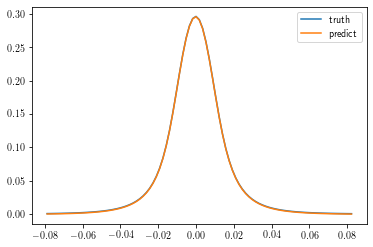

In [138]:
which = np.random.randint(len(y_val))

x_arr, y_hat = model.predict_curves(X_val[which].reshape(1, -1))

plt.plot(xs, y_val[which], label='truth')
plt.plot(x_arr, y_hat.flatten(), label='predict')
plt.legend()


## Save our model to disk
If we're happy, we can save our model to disk.

In [139]:
path = './flux_curve_model_2021_05_11.model'
model.save(path)

## Load model from disk

In [140]:
path = './flux_curve_model_2021_05_11.model'
model = CurveModel.load(path)

## Make sure our model still passes the sanity checks

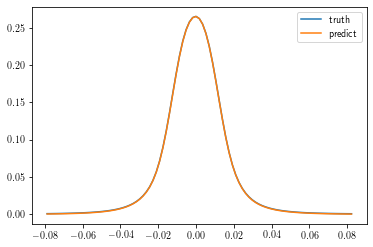

In [142]:
which = np.random.randint(len(y_val))
x_arr, y_hat = model.predict_curves(X_val[which].reshape(1, -1))

plt.plot(xs, y_val[which], label='truth')
plt.plot(x_arr, y_hat.flatten(), label='predict')
plt.legend()

# Evaluation
Let's do our full evaluation.

In [143]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

X, y = create_sklearn_inputs_and_targets(training_samples)
winding_num_z = [sample['winding_num_z'] for sample in training_samples]
winding_num_r = [sample['winding_num_r'] for sample in training_samples]


_, y_hat = model.predict_curves(X)

# Due to the large difference in curve size, we should regularize our curves before calculating the error
y_score, y_hat_score = normalize(y, y_hat)

mae = [mean_absolute_error(y, y_hat) for y, y_hat in zip(y_score, y_hat_score)] 
mse = [mean_squared_error(y, y_hat) for y, y_hat in zip(y_score, y_hat_score)] 
mape = [mean_absolute_percentage_error(y, y_hat) for y, y_hat in zip(y_score, y_hat_score)] 
    
df = pd.DataFrame({
    'winding_num_z': winding_num_z,
    'winding_num_r': winding_num_r,
    'mse': mse,
    'mae': mae,
    'mape': mape
})

df.head()

,winding_num_z,winding_num_r,mse,mae,mape
0,1,1,33.669124,2.840918,10566.881229
1,1,6,0.275660,0.277744,1855.450801
2,1,11,0.065285,0.151966,1736.100258
3,1,16,0.060607,0.137628,1489.880885
4,1,21,0.056685,0.129458,1235.168658


# Error plots

In [144]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

from phd_plotnine_theme import phd_theme_heatmap, phd_theme, phd_theme_bigger 

In [145]:
# Do some clean-up
df = df.drop(df.query('winding_num_z == 1 and winding_num_r == 1').index)
df = df.drop(df.query('winding_num_z == 100').index)

In [146]:
df.sort_values('mae', ascending=False)

,winding_num_z,winding_num_r,mse,mae,mape
41,6,1,9.607939e-01,0.474484,3186.616527
1,1,6,2.756600e-01,0.277744,1855.450801
82,11,1,2.690157e-01,0.257415,2843.669765
123,16,1,1.090244e-01,0.166740,2367.726453
2,1,11,6.528525e-02,0.151966,1736.100258
...,...,...,...,...,...
177,21,66,8.055057e-07,0.000472,1.025182
218,26,66,4.062044e-07,0.000453,4.527086
256,31,51,5.589555e-07,0.000419,1.352605
257,31,56,4.105826e-07,0.000394,2.794087


/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 7 x 7 in image.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_mae_small.png


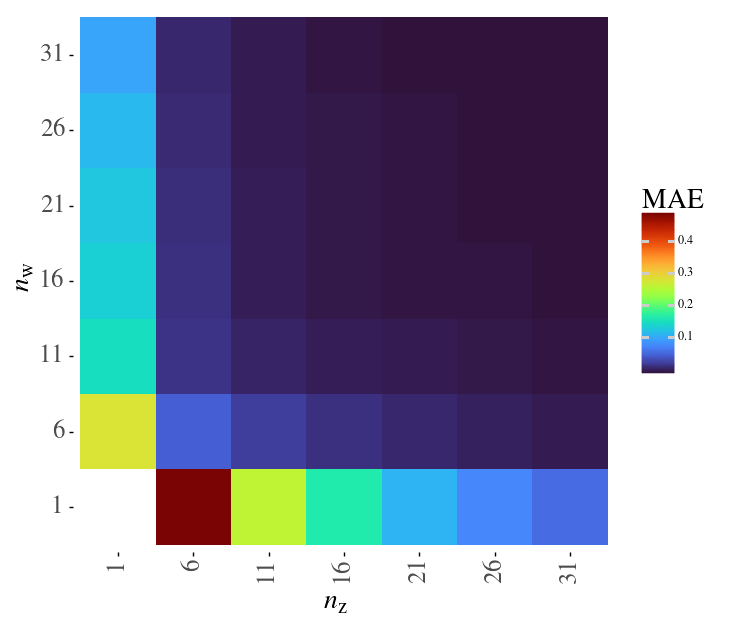

<ggplot: (-9223363303610076770)>

In [147]:
p = ggplot(aes(x='factor(winding_num_z)', y='factor(winding_num_r)', fill='mae'), df.query('winding_num_z < 32 and winding_num_r < 32'))
p = (
  p
    + geom_tile()
    + coord_equal()
    + xlab('$n_{\mathrm{z}}$')
    + ylab('$n_{\mathrm{w}}$')
    + labs(fill='MAE')
    + scale_fill_cmap('turbo')
    + phd_theme_heatmap()
    + theme(
        axis_text_x=element_text(angle=90),
        figure_size=(7,7),
        axis_text=element_text(size=18),
        axis_title=element_text(size=20),
        legend_title=element_text(size=20)
    )
)
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_mae_small.png', dpi=200)
p

/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 7 x 7 in image.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_mae.png


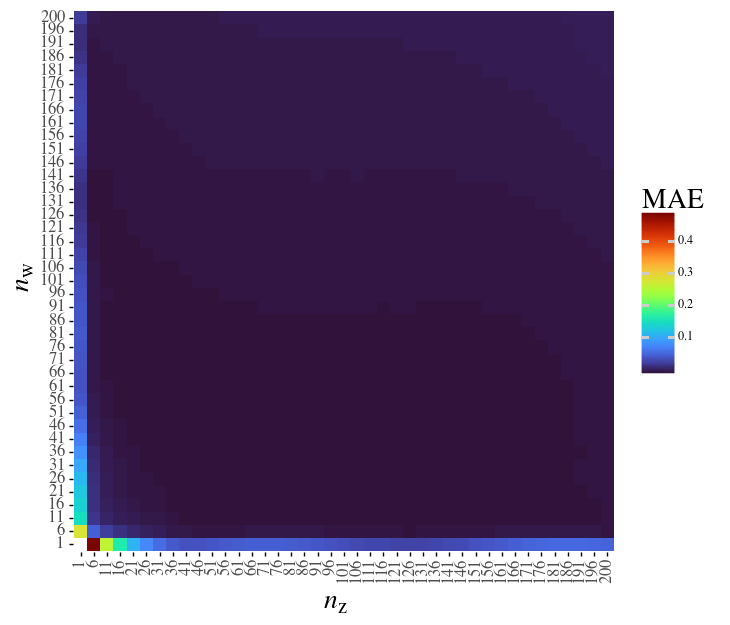

<ggplot: (-9223363303610186706)>

In [148]:
p = ggplot(aes(x='factor(winding_num_z)', y='factor(winding_num_r)', fill='mae'), df)
p = (
  p
    + geom_tile()
    + coord_equal()
    + xlab('$n_{\mathrm{z}}$')
    + ylab('$n_{\mathrm{w}}$')
    + labs(fill='MAE')
    + scale_fill_cmap('turbo')
    + phd_theme_heatmap()
    + theme(
        axis_text_x=element_text(angle=90),
        figure_size=(7,7),
        axis_text=element_text(size=12),
        axis_title=element_text(size=20),
        legend_title=element_text(size=20)
    )
)
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_mae.png', dpi=200)
p

## Flux curve comparisons (unnormalized)

In [150]:
from itertools import product
to_sample = [1, 6, 21, 31, 61, 151]

product = list(product(to_sample, to_sample))

nz_list = []
nw_list = []
flux = []
flux_hat = []
for i, ts in enumerate(training_samples):
    for nz, nw in product:
        if ts['winding_num_z'] == nz and ts['winding_num_r'] == nw:
            nz_list.append(ts['winding_num_z'])
            nw_list.append(ts['winding_num_r'])
            flux.append(ts['dataframe']['flux_linkage'].values)
            flux_hat.append(y_hat[i])

#flux, flux_hat = normalize(flux, flux_hat)
            
df_grid = pd.DataFrame({
    'nz': nz_list,
    'nw': nw_list,
    'phi': flux,
    'phihat': flux_hat
})

In [152]:
df_melt = df_grid.explode(column='phi')
df_melt['phihat'] = df_grid.explode(column='phihat')['phihat'].values

df_melt['phi'] = df_melt['phi'].astype(float)
df_melt['phihat'] = df_melt['phihat'].astype(float)

p_list = list(range(0, df_melt.groupby(['nz', 'nw']).count().iloc[0, 0]))*len(product)
df_melt['p'] = p_list

df_melt = df_melt.melt(id_vars=['nz', 'nw', 'p'])

df_melt['variable'] = df_melt['variable'].apply(lambda x: '$\phi_{0}$' if x == 'phi' else '$\hat{\phi}_{0}$')

df_melt = df_melt.drop(df_melt.query('nz == 1 and nw == 1').index)

df_melt = df_melt.rename(columns={'nz': '$n_{\mathrm{z}}$'})
df_melt = df_melt.rename(columns={'nw': '$n_{\mathrm{w}}$'})
df_melt.head()

,$n_{\mathrm{z}}$,$n_{\mathrm{w}}$,p,variable,value
93,1,6,0,$\phi_{0}$,1.387548e-07
94,1,6,1,$\phi_{0}$,1.537364e-07
95,1,6,2,$\phi_{0}$,1.705559e-07
96,1,6,3,$\phi_{0}$,1.889002e-07
97,1,6,4,$\phi_{0}$,2.099363e-07


/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 12 in image.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_examples.pdf


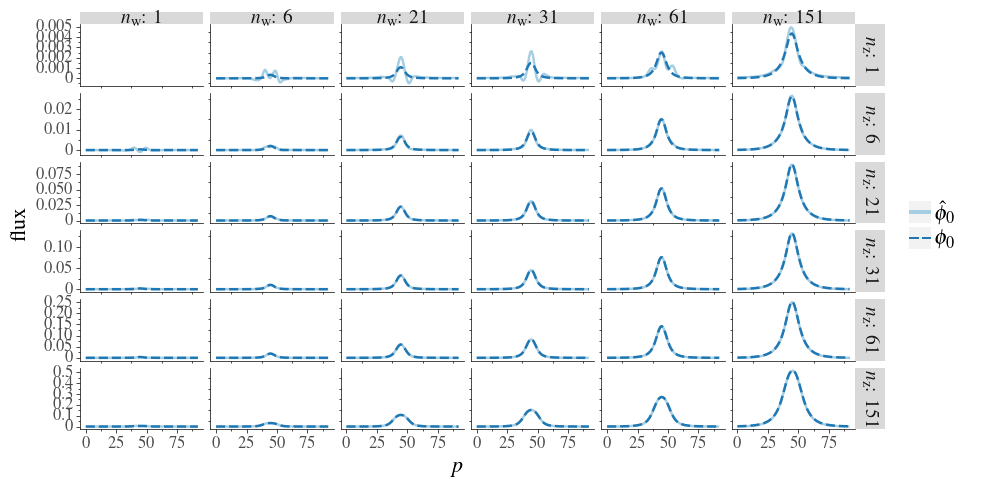

<ggplot: (-9223363303614649782)>

In [155]:
p = ggplot(aes(x='p', y='value', linetype='factor(variable)', color='factor(variable)'), df_melt)
p = (p
     + geom_line(size=1)
     + scale_color_brewer('qual', 3)
     + facet_grid('$n_{\mathrm{z}}$ ~ $n_{\mathrm{w}}$', scales='free_y', labeller='label_both') 
     + theme(figure_size=(10, 12),
             panel_background=element_blank(),
             panel_grid=element_blank(),
             axis_line=element_line(color='black', size=0.5),
             axis_ticks=element_line(size=0.5),
             axis_title_x=element_text(size=16),
             axis_title_y=element_text(size=16),
             axis_text_x=element_text(size=12),
             axis_text_y=element_text(size=12),
             strip_text=element_text(size=14),
             legend_title=element_blank(),
             legend_text=element_text(size=16),
             aspect_ratio=0.5,
            )
     + labs(x='$p$', y='$\mathrm{flux}$')
    )
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_examples.pdf')
p

## Flux curve comparisons (normalized)

In [156]:
from itertools import product
to_sample = [1, 6, 21,31, 61, 151]

product = list(product(to_sample, to_sample))

nz_list = []
nw_list = []
flux = []
flux_hat = []
for i, ts in enumerate(training_samples):
    for nz, nw in product:
        if ts['winding_num_z'] == nz and ts['winding_num_r'] == nw:
            nz_list.append(ts['winding_num_z'])
            nw_list.append(ts['winding_num_r'])
            flux.append(ts['dataframe']['flux_linkage'].values)
            flux_hat.append(y_hat[i])

flux, flux_hat = normalize(flux, flux_hat)
            
df_grid = pd.DataFrame({
    'nz': nz_list,
    'nw': nw_list,
    'phi': flux,
    'phihat': flux_hat
})


df_melt = df_grid.explode(column='phi')
df_melt['phihat'] = df_grid.explode(column='phihat')['phihat'].values

df_melt['phi'] = df_melt['phi'].astype(float)
df_melt['phihat'] = df_melt['phihat'].astype(float)

p_list = list(range(0, df_melt.groupby(['nz', 'nw']).count().iloc[0, 0]))*len(product)
df_melt['p'] = p_list

df_melt = df_melt.melt(id_vars=['nz', 'nw', 'p'])

df_melt['variable'] = df_melt['variable'].apply(lambda x: '$\phi_{0}$' if x == 'phi' else '$\hat{\phi}_{0}$')

df_melt = df_melt.drop(df_melt.query('nz == 1 and nw == 1').index)

df_melt = df_melt.rename(columns={'nz': '$n_{\mathrm{z}}$'})
df_melt = df_melt.rename(columns={'nw': '$n_{\mathrm{w}}$'})
df_melt.head()

,$n_{\mathrm{z}}$,$n_{\mathrm{w}}$,p,variable,value
93,1,6,0,$\phi_{0}$,0.000410
94,1,6,1,$\phi_{0}$,0.000454
95,1,6,2,$\phi_{0}$,0.000504
96,1,6,3,$\phi_{0}$,0.000558
97,1,6,4,$\phi_{0}$,0.000620


/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 12 in image.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_examples_normalized.pdf


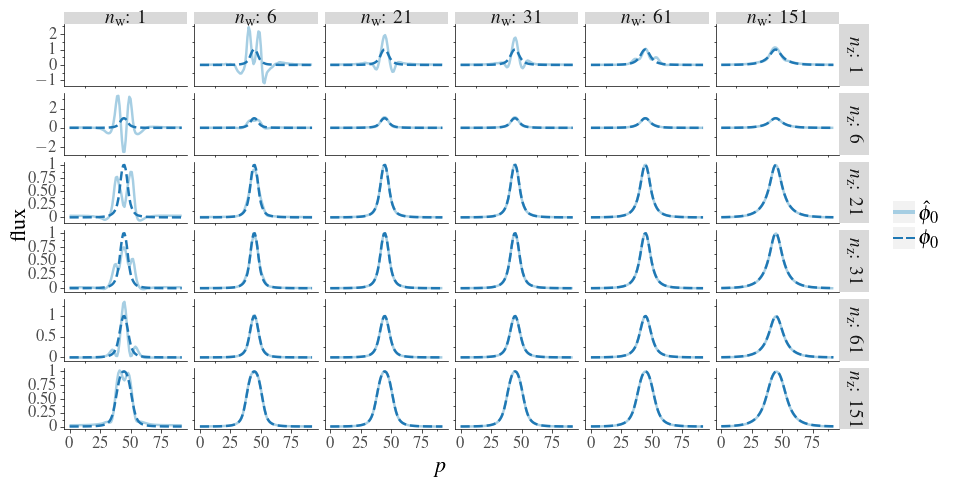

<ggplot: (8733232382493)>

In [158]:
p = ggplot(aes(x='p', y='value', linetype='factor(variable)', color='factor(variable)'), df_melt)
p = (p
     + geom_line(size=1)
     + scale_color_brewer('qual', 3)
     + facet_grid('$n_{\mathrm{z}}$ ~ $n_{\mathrm{w}}$', scales='free_y', labeller='label_both') 
     + theme(figure_size=(10, 12),
             panel_background=element_blank(),
             panel_grid=element_blank(),
             axis_line=element_line(color='black', size=0.5),
             axis_ticks=element_line(size=0.5),
             axis_title_x=element_text(size=16),
             axis_title_y=element_text(size=16),
             axis_text_x=element_text(size=12),
             axis_text_y=element_text(size=12),
             strip_text=element_text(size=14),
             legend_title=element_blank(),
             legend_text=element_text(size=16),
             aspect_ratio=0.5,
            )
     + labs(x='$p$', y='$\mathrm{flux}$')
    )
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/curve_model_examples_normalized.pdf')
p

# Investigate Model with different amounts of training data
**Can be a bit slow to run**